In [1]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

# setup device to use
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, txt_processors = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device
)
model.requires_grad_(True)

/opt/conda/envs/xai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/xai/lib/python3.9/site-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/opt/conda/envs/xai/lib/python3.9/site-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore
/opt/conda/envs/xai/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0

Blip2T5(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
 

### Load image

In [2]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

### Attribution Explanation

In [3]:
import matplotlib.pyplot as plt
from utils.explainer import AttributionExplainer

explainer = AttributionExplainer(model)

In [4]:
samples = {
    "image": image, "prompt": "Describe the image in a sentence."
}
outputs, generated_text = explainer.generate(samples, use_nucleus_sampling=True)
generated_text

/workspace/vl_debugging/utils/base_explainer.py:194: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.model.device != torch.device("cpu"))):


['the merlion statue in singapore at dusk']

In [5]:
tokens = model.t5_tokenizer.convert_ids_to_tokens(outputs.sequences[0].tolist())
tokens

['<pad>',
 '▁the',
 '▁',
 'mer',
 'lion',
 '▁statue',
 '▁in',
 '▁sing',
 'a',
 'pore',
 '▁at',
 '▁du',
 's',
 'k',
 '</s>']

In [6]:
R = explainer.explain(samples, outputs.sequences[:,:-2])

### Attentions of Query tokens (Q -> I)

In [20]:
import torch.nn.functional as F
import math
from utils.visualization import normalize_last_dim, normalize, show_cam_on_image

img_size = image.size(2)

R_qi = R['qi'][:, 1:]
R_qi = normalize_last_dim(R_qi)

num_q, seq_len = R_qi.shape
rc = int(math.sqrt(seq_len))
R_qi = R_qi.view(num_q,1,rc,rc)

ori_img = F.interpolate(image, (img_size, img_size), mode="bilinear")
R_qi = F.interpolate(R_qi, (img_size, img_size), mode='bilinear')

ori_img = normalize(ori_img).squeeze(0)
R_qi = normalize(R_qi)

vis = []
for i in range(R_qi.shape[0]):
    vis.append(show_cam_on_image(ori_img, R_qi[i]))


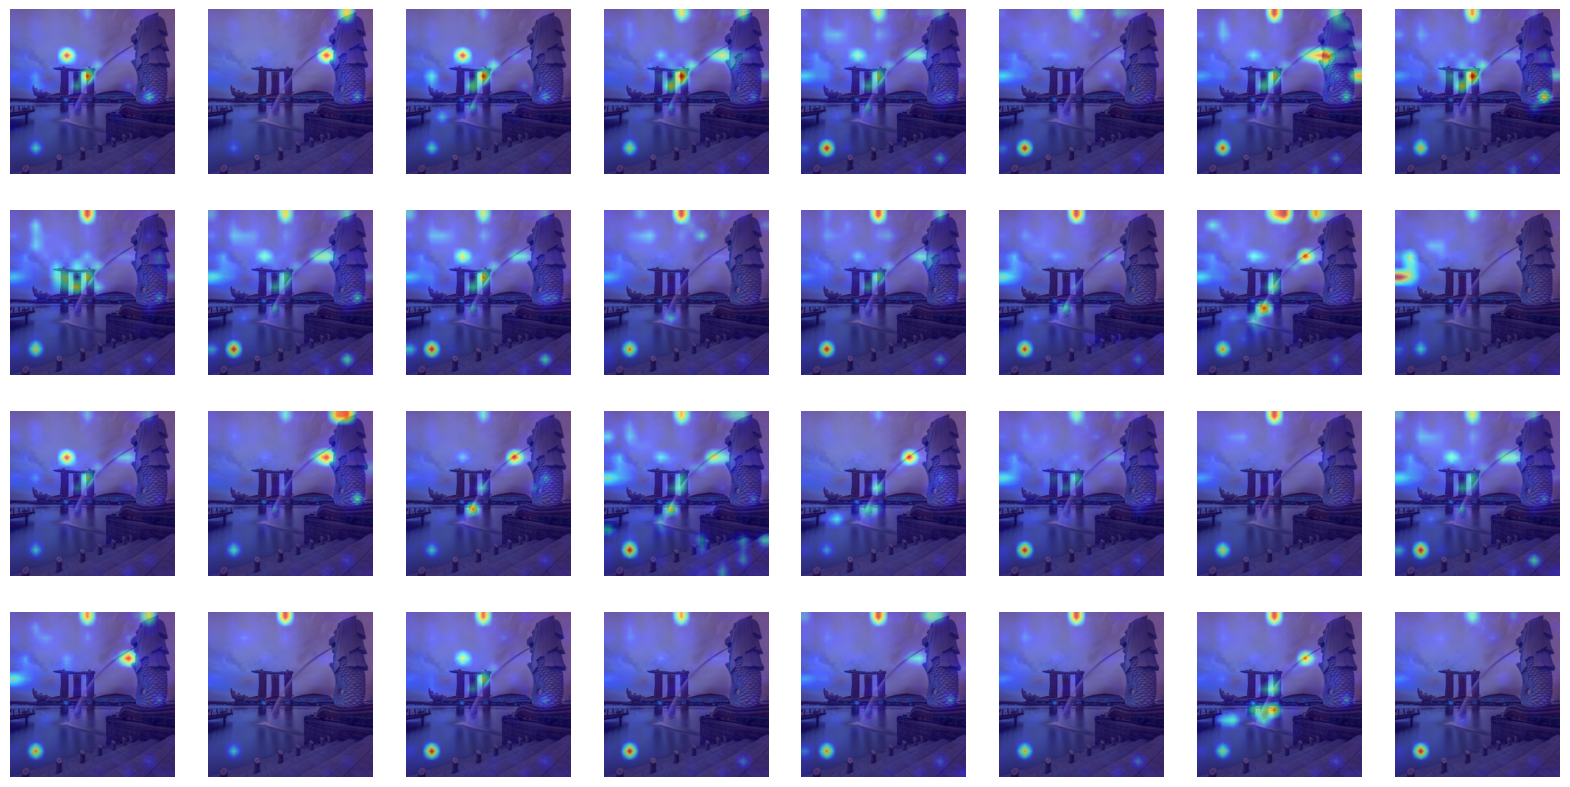

In [21]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(vis[i])
    ax.axis('off')

### Explanation for Decision

Generating relevance for token 1...


/workspace/vl_debugging/utils/base_explainer.py:194: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.model.device != torch.device("cpu"))):


Generating relevance for token 2...
Generating relevance for token 3...
Generating relevance for token 4...
Generating relevance for token 5...
Generating relevance for token 6...
Generating relevance for token 7...
Generating relevance for token 8...
Generating relevance for token 9...
Generating relevance for token 10...
Generating relevance for token 11...
Generating relevance for token 12...
Generating relevance for token 13...


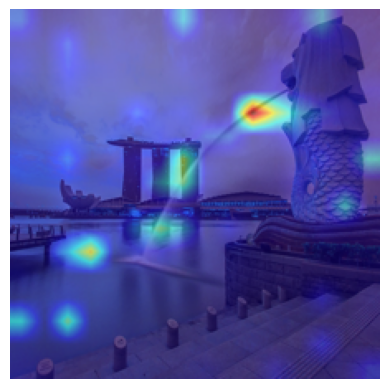

In [22]:
def get_gentext2image(R_de, R_qi, R_ii, target_idx):
    pred2query = R_de[target_idx-1:target_idx,:32] # 1 32
    pred2image = torch.matmul(pred2query, R_qi)
    pred2image = pred2image[:,1:]+pred2image[:,0]*R_ii[0:1,1:] # 1 257
    
    return pred2image

relevances = []
for i in range(1,len(tokens)-1):
    print(f"Generating relevance for token {i}...")
    R = explainer.explain(samples, outputs.sequences[:,:i])
    relevance = get_gentext2image(R['de'], R['qi'], R['ii'], i)
    relevances.append(relevance)
    
relevance = torch.cat(relevances).sum(dim=0)

norm_img = normalize(F.interpolate(image, (224,224), mode="bilinear")).squeeze(0)
norm_cam = normalize(F.interpolate(relevance.view(1,1,16,16),(224,224), mode="bilinear")).squeeze(0)
heatmaps = show_cam_on_image(norm_img, norm_cam)
plt.axis('off')
plt.imshow(heatmaps)